<a href="https://colab.research.google.com/github/danish233/ML-Project/blob/main/CS_4774_Project_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 4774 Machine Learning Project
### Kevin Sandoval (ucy5mh), Emmet Hannam (rym4hc), Danish Chauhan (dic2fx)

## Step 1: Big Picture

See the introduction section of the final report!

## Step 2: Load the Data

In [ ]:
import pandas as pd

import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def loadData():
  # The column names are adopted from the dataset page on Kaggle
  data = pd.read_csv('final_dataset.csv') #the dataset (get from google drive)
  return data

##  Step 3: Data Preparation and Cleaning

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

data = loadData()
# Removing Rows with #N/A
#data.replace('#N/A', np.nan, inplace=True)
data.dropna(subset=['Start of Year Stock Price', 'End of Year Stock Price'], inplace=True)

data.drop(["Index", "Company Name", "State Representative", "Stock Type", "Categorical Value", "Year"], axis=1, inplace=True) #Drop these features because they are irrelevant

data['Stock Difference'] = data['End of Year Stock Price'] - data['Start of Year Stock Price'] #add stock difference column
data['Stock Growth Percentage'] = data['Stock Difference'] / data['Start of Year Stock Price'] #add stock growth column
data_visual_purposes = data.copy()
data.drop(["Stock Difference", "End of Year Stock Price", "Start of Year Stock Price"], axis=1, inplace=True)

num_attribs = list(data.select_dtypes(include=[np.number]))
cat_attribs = list(data.select_dtypes(include=["object"]))
all_attribs = data.columns.array.tolist()

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

def load_company_type_dictionary():
  company_type_dictionary = {} #maps different spellings/capitalization/etc. of company_type to a singular consitent one

  mapping_data = pd.read_csv('company_type_mapping.csv', header=None) #get from google drive

  for index, row in mapping_data.iterrows():
    company_type_dictionary[row.iloc[0]] = row.iloc[1] #first col is key, second col comapny_type to map to

  return company_type_dictionary;

company_type_dictionary = load_company_type_dictionary();

class TransformCatAttributes(BaseEstimator, TransformerMixin): #handle categorical column transformations
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None): #Apply the map to the company/stock type column (to make them consistent)
    #X['Stock Type'] = X['Stock Type'].apply(lambda x: company_type_dictionary.get(x, x))
    return X

class TransformNumAttributes(BaseEstimator, TransformerMixin): #handle numeric column transformations
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    return X.values

num_pipeline = Pipeline(steps=[
    ("attribs_adder", TransformNumAttributes()),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline(steps=[
    ("attribs_adder", TransformCatAttributes()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="infrequent_if_exist")),
])

full_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs),
])

data_prepared = full_pipeline.fit_transform(train_set)

## Step 4. Discover and visualize the data to gain insights


Histogram Data:



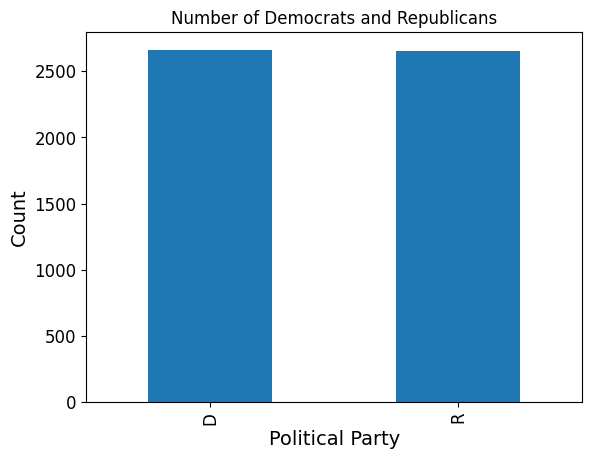

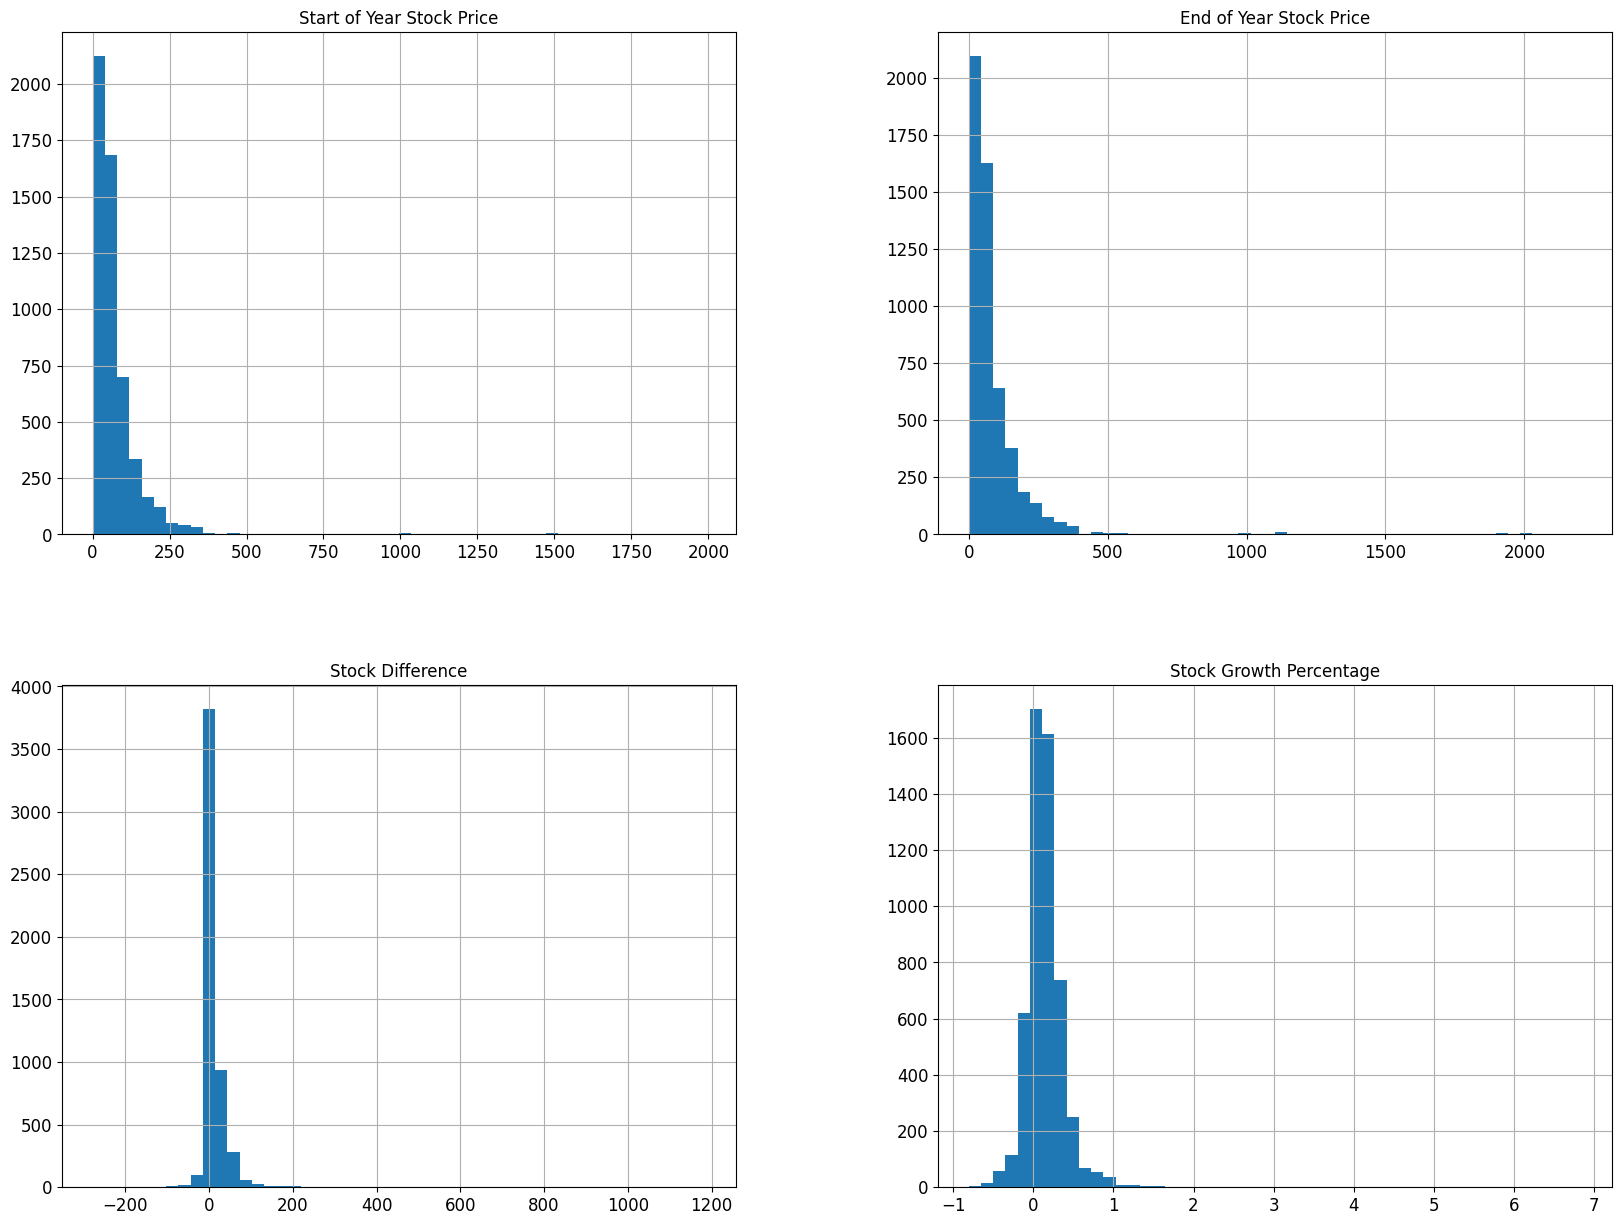

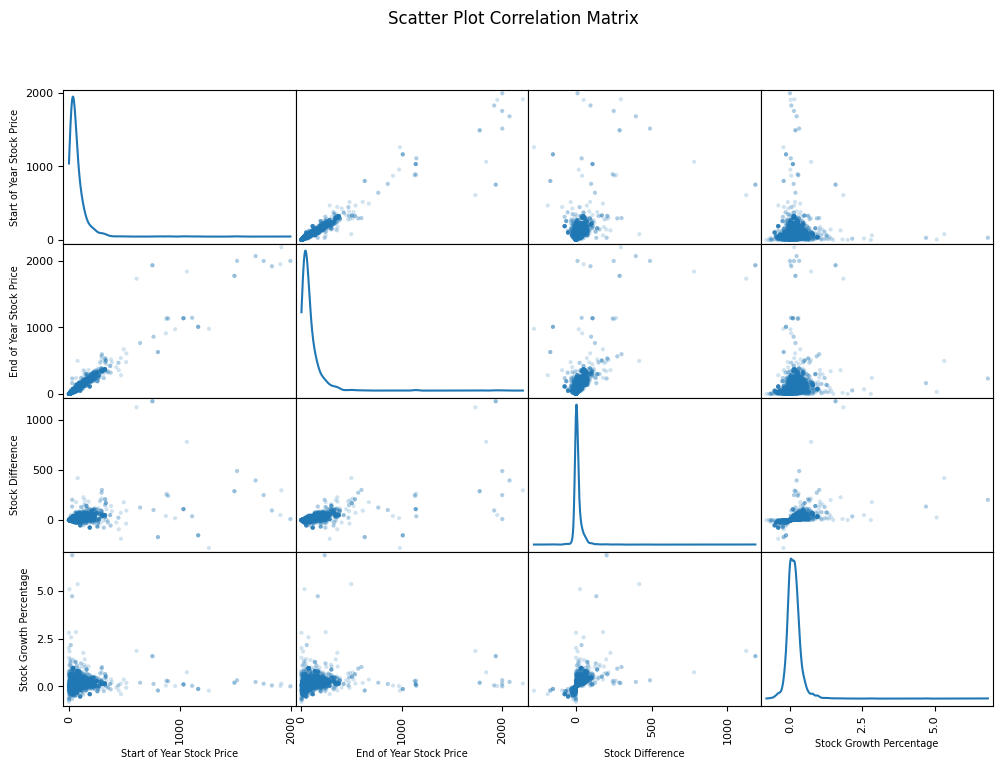


Some Satistics:

       Stock Growth Percentage
count              5316.000000
mean                  0.148216
std                   0.302408
min                  -0.807692
25%                   0.005329
50%                   0.125263
75%                   0.246367
max                   6.842533

First few rows of the cleaned dataset:


,Political Party,Sector,Stock Growth Percentage
32,D,Consumer Goods,4.703470
33,D,Consumer Goods,4.703470
34,D,Consumer Goods,1.347788
35,D,Consumer Goods,1.175268
36,D,Consumer Goods,1.031334


In [ ]:
# TODO:
# 1. Describe data statstics (mean, stdev, etc.)
# 2. Visualize the data (some type of graph)
from pandas.plotting import scatter_matrix

# 'Cleans' the dataset without performing scaling or onehotencoding, data variable isn't reused so fine to apply transformations. For visualization purposes
data_visual_purposes = pd.DataFrame(TransformNumAttributes().fit_transform(data_visual_purposes), columns=data_visual_purposes.columns.array.tolist())
data_visual_purposes = pd.DataFrame(TransformCatAttributes().fit_transform(data_visual_purposes), columns=data_visual_purposes.columns.array.tolist())
data_visual_purposes['Start of Year Stock Price'] = pd.to_numeric(data_visual_purposes['Start of Year Stock Price'], errors='coerce')
data_visual_purposes['End of Year Stock Price'] = pd.to_numeric(data_visual_purposes['End of Year Stock Price'], errors='coerce')
data_visual_purposes['Stock Difference'] = pd.to_numeric(data_visual_purposes['Stock Difference'], errors='coerce')
data_visual_purposes['Stock Growth Percentage'] = pd.to_numeric(data_visual_purposes['Stock Growth Percentage'], errors='coerce')

numerical_columns = list(data_visual_purposes.select_dtypes(include=[np.number]))

print("\nHistogram Data:\n")
# Histogram of Political Party
data_visual_purposes['Political Party'].value_counts().plot(kind='bar')
plt.title('Number of Democrats and Republicans')
plt.xlabel('Political Party')
plt.ylabel('Count')
plt.show()

# Histogram of Stocks bought per year
# This assumes there is a 'Year' column in your dataset
if 'Year' in data_visual_purposes:
  data_visual_purposes['Year'].value_counts().sort_index().plot(kind='bar')
  plt.title('Number of Stocks Bought per Year')
  plt.xlabel('Year')
  plt.ylabel('Count')
  plt.show()

# This histogram first requires the stock type column to be cleaned up (transformer function)
# Histogram of Types of Funds
# This assumes you have a column 'Fund Type' that categorizes the types of funds
#data['Stock Type'].value_counts().plot(kind='bar')
# plt.title('Numbers of Types of Funds')
# plt.xlabel('Stock Type')
# plt.ylabel('Count')
# plt.show()

data_visual_purposes[numerical_columns].hist(bins=50, figsize=(20,15))
plt.show()

scatter_matrix_plot = scatter_matrix(data_visual_purposes[numerical_columns], alpha=0.2, figsize=(12, 8), diagonal='kde')

# Set labels for axes
for ax in scatter_matrix_plot[-1, :]:
    ax.set_xlabel(numerical_columns[scatter_matrix_plot[-1, :].tolist().index(ax)])
    ax.xaxis.label.set_fontsize(7)

for ax in scatter_matrix_plot[:, 0]:
    ax.set_ylabel(numerical_columns[scatter_matrix_plot[:, 0].tolist().index(ax)])
    ax.yaxis.label.set_fontsize(7)

plt.suptitle("Scatter Plot Correlation Matrix")
plt.show()

# Plot histograms

print("\nSome Satistics:\n")
print(data.describe())

print("\nFirst few rows of the cleaned dataset:")
data.head()

## Step 5: Model Selection


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


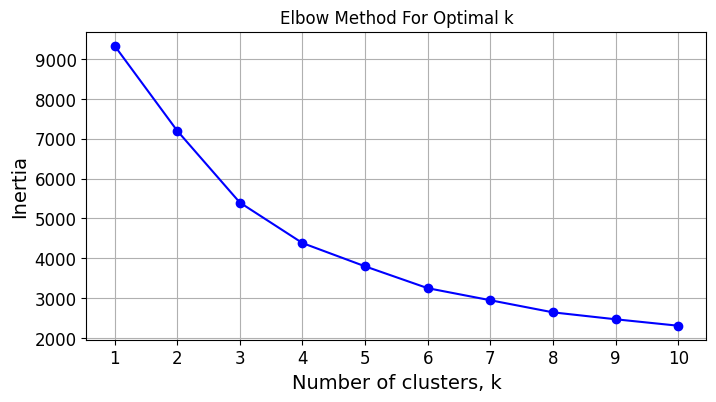

Cluster 0 SSE: 180.80698973183155
Cluster 0 mean values:
Stock Growth Percentage    0.098716
Cluster                    0.000000
dtype: float64
Cluster 0 one-hot encoded mean values:
Number of one hot labels: 10
Number of points in cluster: 1109
Political Party_D: [[1.]]
Political Party_R: [[0.]]
Sector_Consumer Goods: [[0.]]
Sector_Finance: [[0.]]
Sector_Fund/Investment: [[1.]]
Sector_Healthcare: [[0.]]
Sector_Industrial: [[0.]]
Sector_Real Estate: [[0.]]
Sector_Technology: [[0.]]
Sector_Utilities: [[0.]]

Cluster 1 SSE: 1157.550940856109
Cluster 1 mean values:
Stock Growth Percentage    0.09844
Cluster                    1.00000
dtype: float64
Cluster 1 one-hot encoded mean values:
Number of one hot labels: 10
Number of points in cluster: 964
Political Party_D: [[0.]]
Political Party_R: [[1.]]
Sector_Consumer Goods: [[0.21369295]]
Sector_Finance: [[0.27385892]]
Sector_Fund/Investment: [[0.]]
Sector_Healthcare: [[0.08713693]]
Sector_Industrial: [[0.19294606]]
Sector_Real Estate: [[0.0

<ipython-input-118-a23058af36e4>:38: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(cluster_data.mean())
<ipython-input-118-a23058af36e4>:38: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(cluster_data.mean())
<ipython-input-118-a23058af36e4>:38: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  p

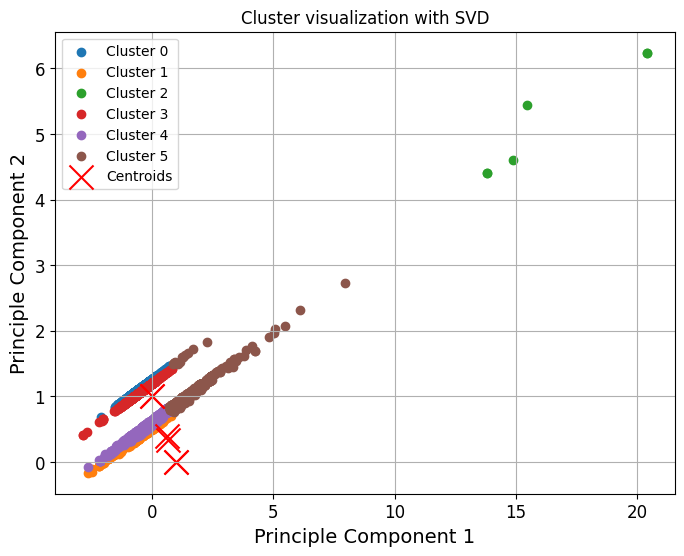

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

#Elbow method to find best k value. Commenting out and not implementing for now
def find_optimal_clusters(data, max_k=10):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, max_k + 1), inertias, 'bo-')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)
    plt.show()

find_optimal_clusters(data_prepared)

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
train_set['Cluster'] = kmeans.fit_predict(data_prepared)

cluster_sses=[0 for i in range(k)]
for point, label in zip(data_prepared, kmeans.labels_):
    cluster_sses[label] += np.square(point - kmeans.cluster_centers_[label]).sum()

for i in range(k):
    cluster_data = train_set[train_set['Cluster'] == i]
    centroid = kmeans.cluster_centers_[i]

    print(f"Cluster {i} SSE:", cluster_sses[i])
    print(f"Cluster {i} mean values:")
    print(cluster_data.mean())

    one_hot_labels = full_pipeline.transformers_[0][1]['onehot'].get_feature_names_out(input_features=cat_attribs)

    print(f"Cluster {i} one-hot encoded mean values:")
    one_hot_means = data_prepared[train_set['Cluster'] == i][:, (len(num_attribs) - 1):].mean(axis=0)

    one_hot_means = one_hot_means.transpose()

    print(f"Number of one hot labels: {len(one_hot_labels)}")

    print(f"Number of points in cluster: {len(cluster_data)}")

    for col, mean in zip(one_hot_labels, one_hot_means):
      print(f"{col}: {mean}")

    print()

from sklearn.decomposition import TruncatedSVD

# Perform TruncatedSVD for visualization purposes
svd = TruncatedSVD(n_components=2)
data_svd = svd.fit_transform(data_prepared)

# Include the SVD transformation in the original train set for plotting
train_set['SVD1'] = data_svd[:, 0]
train_set['SVD2'] = data_svd[:, 1]

# Plotting each cluster
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(train_set.loc[train_set['Cluster'] == i, 'SVD1'],
                train_set.loc[train_set['Cluster'] == i, 'SVD2'],
                label=f'Cluster {i}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=300, c='red', label='Centroids', marker='x')

plt.title('Cluster visualization with SVD')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend()
plt.grid(True)
plt.show()